# 目标检测7日打卡营作业四：Anchor-Free系列模型实战

## 实战数据集及框架

- 印刷电路板（PCB）瑕疵数据集：[数据下载链接](http://robotics.pkusz.edu.cn/resources/dataset/)，是一个公共的合成PCB数据集，由北京大学发布，其中包含1386张图像以及6种缺陷（缺失孔，鼠标咬伤，开路，短路，杂散，伪铜），用于检测，分类和配准任务。我们选取了其中适用与检测任务的693张图像，随机选择593张图像作为训练集，100张图像作为验证集。
- PaddleDetection：飞桨推出的PaddleDetection是端到端目标检测开发套件，旨在帮助开发者更快更好地完成检测模型的训练、精度速度优化到部署全流程。该框架中提供了丰富的数据增强、网络组件、损失函数等模块，集成了模型压缩和跨平台高性能部署能力。目前基于PaddleDetection已经完成落地的项目涉及工业质检、遥感图像检测、无人巡检等多个领域。

## 作业描述
基于PaddleDetection中的Anchor-Free系列算法，完成印刷电路板（PCB）瑕疵数据集的训练与评估任务，在验证集上采用IoU=0.5，area=all的mAP作为评价指标，得分=mAP * 100，范围[0,100]，分数越高模型效果越好，及格线是90分。鼓励大家使用GPU训练，CPU训练的结果不纳入排行榜。

提示：
1. 增大训练轮数有助于网络收敛的更好，可提高mAP；
2. 在PaddleDetection的configs中有不同种类的Anchor-Free系列模型，可以寻找Anchor-Free系列性能更强的模型配置文件。

## Baseline基线代码
目前基线模型训练12个Epoch(1x)后，mAP达到0.92，但还有优化的空间，转动你的大脑开始debug吧^-^

### 数据准备
首先将印刷电路板（PCB）瑕疵数据集与PaddleDetection代码解压到`~/work/`目录中：

In [ ]:
# 解压数据集
!tar -xf data/data52914/PCB_DATASET.tar -C ~/work/
# 解压PaddleDetection源码
!tar -xf data/data52899/PaddleDetection.tar -C ~/work/

tar: data/data52914/PCB_DATASET.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
tar: data/data52899/PaddleDetection.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


### 环境安装
进行训练前需要安装PaddleDetection所需的依赖包，执行以下命令即可安装：

In [1]:
%cd ~/work/PaddleDetection
! pip install -r requirements.txt
! pip install pycocotools

/home/aistudio/work/PaddleDetection
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 1.0MB 14.2MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple/
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=278380 sha256=85ed6d73edb887aad2b17ca3ad721f8720445040ac7c25c98ace6192be265122
  Stored in directory: /home/aistudio/.cache/pip/wheels/fb/44/67/8baa69040569b1edbd7776ec6f82c387663e724908aaa60963
Successfully built pycocotools


## 修改配置文件
PaddleDetection中提供的配置文件是在8卡GPU环境下的配置，我们需要调整配置文件：
包括最大训练轮数(max_iters)，类别数(num_classes)，学习率(LearningRate)相关参数，数据Reader中TrainReader与EvalReader数据集路径等参数。

提示：
- 为保证模型正常训练不出Nan，学习率要根据GPU卡数，batch size变换而做线性变换，比如这里我们只将GPU卡数8->1，所以base_lr除以8即可；
- 训练轮数与Epoch转换关系：根据训练集数量与总batch_size大小计算epoch数，然后将epoch数换算得到训练总轮数max_iters。配置文件中batch_size=2，训练集数量为593，要训练12个Epoch，在单卡GPU上训练，max_iters=593x12/2=3558。同时需要计算milestones（学习率变化界限），一般在总epoch数的2/3和8/9处进行学习率的调整，所以milestones为: [2372, 3163]。（PS：建议增大训练轮数）

### fcos_r50_fpn_1x.yml配置文件修改适配：
- max_iters: 3558
- num_classes: 6
- base_lr: 0.00025
- milestones: [2372, 3163]

### fcos_r50_fpn_1x.yml配置文件Reader修改适配：
TrainReader:
- image_dir: images
- anno_path: Annotations/train.json
- dataset_dir: /home/aistudio/work/PCB_DATASET

EvalReader:
- image_dir: images
- anno_path: Annotations/val.json
- dataset_dir: /home/aistudio/work/PCB_DATASET

TestReader:
- anno_path: /home/aistudio/work/PCB_DATASET/Annotations/val.json

In [ ]:
%cd ./output/fcos_r50_fpn_1x/mod

/home/aistudio/work/PaddleDetection


In [3]:
! python -u tools/train.py -c ../fcos_r50_fpn.yml --eval
### ！！！CPU下训练执行如下指令！！！
#! python -u tools/train.py -c ../fcos_r50_fpn_1x_cpu.yml --eval -o use_gpu=False pretrain_weights=../fcos_r50_fpn_1x.pdparams

2020-09-28 20:06:51,993-WARNING: paddle.fluid.layers.matrix_nms OP not found, maybe a newer version of paddle is required.
2020-09-28 20:06:52,950-INFO: If regularizer of a Parameter has been set by 'fluid.ParamAttr' or 'fluid.WeightNormParamAttr' already. The Regularization[L2Decay, regularization_coeff=0.000100] in Optimizer will not take effect, and it will only be applied to other Parameters!
2020-09-28 20:06:54,076-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-09-28 20:06:54,513-INFO: generated new fontManager
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-28 20:06:54,915-INFO: places would be ommited when DataLoader is not iterable
W0928 20:06:54.943

### 评估与预测
如果在训练中加了`--eval`参数，在模型训练完就可得到mAP指标，如果要对模型单独计算mAP，可以运行：

In [ ]:
 ! python -u tools/eval.py -c ../fcos_r50_fpn_1x.yml \
                -o weights=output/fcos_r50_fpn_1x/best_model
### ！！！CPU下训练执行如下指令！！！
# ! python -u tools/eval.py -c ../fcos_r50_fpn_1x_cpu.yml \
#                 -o weights=output/fcos_r50_fpn_1x_cpu/best_model \
#                 use_gpu=false

2020-09-28 13:02:02,994-WARNING: paddle.fluid.layers.matrix_nms OP not found, maybe a newer version of paddle is required.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-28 13:02:04,045-INFO: places would be ommited when DataLoader is not iterable
W0928 13:02:04.081609  9898 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 9.2, Runtime API Version: 9.0
W0928 13:02:04.086426  9898 device_context.cc:260] device: 0, cuDNN Version: 7.6.
^C


对印刷电路板（PCB）瑕疵数据集个别图片进行可视化预测，可以运行：

In [6]:
! python -u tools/infer.py -c ../fcos_r50_fpn.yml \
                --infer_img=../PCB_DATASET/images/04_missing_hole_10.jpg \
                -o weights=output/fcos_r50_fpn/best_model
### ！！！CPU下训练执行如下指令！！！
# ! python -u tools/infer.py -c ../fcos_r50_fpn_1x_cpu.yml \
#                 --infer_img=../PCB_DATASET/images/04_missing_hole_10.jpg \
#                 -o weights=output/fcos_r50_fpn_1x_cpu/best_model \
#                 use_gpu=false

2020-09-28 20:31:32,406-WARNING: paddle.fluid.layers.matrix_nms OP not found, maybe a newer version of paddle is required.
W0928 20:31:33.203068  1335 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 9.2, Runtime API Version: 9.0
W0928 20:31:33.208279  1335 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2020-09-28 20:31:37,848-INFO: Load categories from /home/aistudio/work/PCB_DATASET/Annotations/val.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-28 20:31:39,223-INFO: Infer iter 0
2020-09-28 20:31:39,376-INFO: Detection bbox results save in output/04_missing_hole_10.jpg


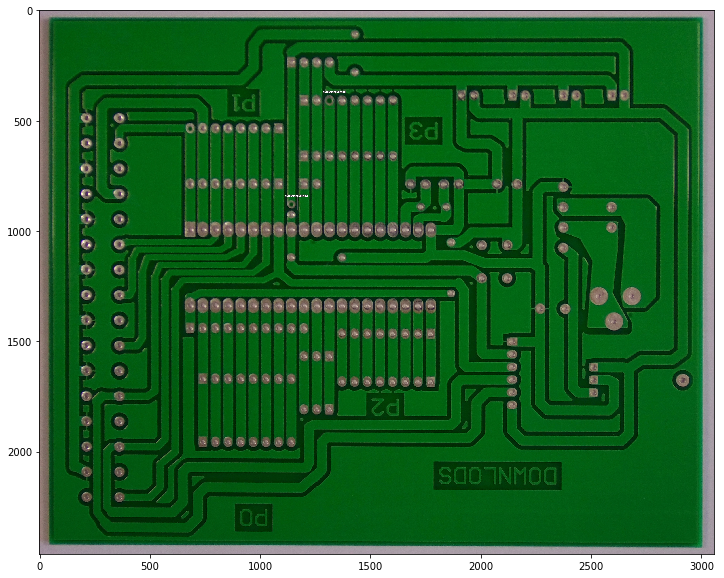

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 
import cv2

infer_img = cv2.imread("output/04_missing_hole_10.jpg")
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(infer_img, cv2.COLOR_BGR2RGB))
plt.show()